# Iberdrola Project - Phase 2 [Occupancy Detection]

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [10]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)
Is GPU Initialized yet? True
2.1.2+cu121


# Import Libraries

In [11]:
import os
import h5py
import scipy
import random
import pickle
import json
import configparser
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.io import loadmat, savemat
from pathlib import Path
from tqdm import tqdm
from scipy import stats

In [12]:
%matplotlib inline
sns.set_style('white')

# Import and Prepare Data

## Prepare Dataset for Training

Import and Extract Data

In [13]:
# Import
fl_Data = h5py.File(os.path.join('Raw_Data/Phase_2_Exp_2/H04_Data_Matched_Occupancy.mat'), 'r')
print(fl_Data.keys())
# Extract
X_Data = np.swapaxes(np.swapaxes(np.array(fl_Data['data_plugs']),0,1),1,2)
Y_Data = np.expand_dims(np.array(fl_Data['data_occupancy']), axis=2)
X_Data_shape = X_Data.shape
Y_Data_shape = Y_Data.shape
print(X_Data_shape)
print(Y_Data_shape)
sample_num = X_Data_shape[0]
segment_length = X_Data_shape[1]
num_channels = X_Data_shape[2]
# Check for NaNs and InFs
data = pd.Series(X_Data.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
data = pd.Series(Y_Data.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())

<KeysViewHDF5 ['data_occupancy', 'data_plugs', 'data_sm']>
(86, 86400, 7)
(86, 86400, 1)
False
False
False
False


Plot Raw Segments

In [ ]:
segment_length = 86400
i = random.randint(0, X_Data_shape[0])
plt.figure(figsize=(32,21))
'''Fridge'''
plt.subplot(8,1,1)
plt.plot(X_Data[i,:,0], linewidth=3, label='Fridge GT', color='navy')
plt.title(f"House 04 - Fridge - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kitchen Appliances'''
plt.subplot(8,1,2)
plt.plot(X_Data[i,:,1], linewidth=3, label='Kitchen Appliances GT', color='navy')
plt.title(f"Kitchen Appliances", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Lamp'''
plt.subplot(8,1,3)
plt.plot(X_Data[i,:,2], linewidth=3, label='Lamp GT', color='navy')
plt.title(f"Lamp", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Laptop'''
plt.subplot(8,1,4)
plt.plot(X_Data[i,:,3], linewidth=3, label='Laptop GT', color='navy')
plt.title(f"Laptop", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Freezer'''
plt.subplot(8,1,5)
plt.plot(X_Data[i,:,4], linewidth=3, label='Freezer GT', color='navy')
plt.title(f"Freezer", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Entertainment'''
plt.subplot(8,1,6)
plt.plot(X_Data[i,:,5], linewidth=3, label='Entertainment GT', color='navy')
plt.title(f"Entertainment", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Microwave'''
plt.subplot(8,1,7)
plt.plot(X_Data[i,:,6], linewidth=3, label='Microwave GT', color='navy')
plt.title(f"Microwave", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Occupancy Label'''
plt.subplot(8,1,8)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

Data Pruning - Select channels with an acceptable number of datapoints (optional, for only multichannel)

In [14]:
thresh = 0.05
X_Data_Pruned = np.zeros((sample_num,segment_length,num_channels))
device_list = ['Fridge','Kitchen_Appliances','Lamp','Laptop','Freezer','Entertainment','Microwave']
counter = 0
for i in range(0,num_channels):
    data_current_channel = X_Data[:,:,i]
    data_current_channel_corr, _ = stats.pearsonr(data_current_channel.ravel(), Y_Data.ravel())
    # data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_corr < thresh) or (i == 0) or (i == 4):
        print(device_list[i])
        print(data_current_channel_corr)
        continue
    else:
        X_Data_Pruned[:,:,counter] = data_current_channel
        counter = counter + 1
X_Data_Pruned = X_Data_Pruned[:,:,0:counter]
X_Data_Shape = X_Data_Pruned.shape
num_channels = X_Data_Shape[2]
print(X_Data_Pruned.shape)
print(Y_Data.shape)

Fridge
-0.0006008372030482734
Kitchen_Appliances
0.02398692047379853
Lamp
0.005957090305768786
Laptop
0.008389735251117126
Freezer
-0.029938059934224038
Microwave
0.026233799818792633
(86, 86400, 1)
(86, 86400, 1)


Transform Data

In [15]:
X_Data_Shape = X_Data_Pruned.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_New = np.zeros((sample_num,segment_length,num_channels))
# Step 1: Range Normalize Data based on [0 1] threshold
counter = 0
threshold1 = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_Pruned[i,:,:]
    for ii in range(0,num_channels):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        for iii in range(0,segment_length):
            X_Data_Temp_Ch_Point = X_Data_Temp_Ch[iii]
            if X_Data_Temp_Ch_Point > threshold1:
                X_Data_Temp_Ch_Point = 1
            X_Data_New[counter,iii,ii] = X_Data_Temp_Ch_Point
    counter = counter + 1
X_Data_New = np.int_(X_Data_New[0:counter,:,:])
print(X_Data_New.shape)
print(Y_Data.shape)
print(np.unique(X_Data_New))

(86, 86400, 1)
(86, 86400, 1)
[0 1]


In [16]:
# Step 2: Merge short pulses into longer one based on threshold duration
X_Data_Shape = X_Data_New.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
counter = 0
threshold2 = 3600
for i in range(0,sample_num):
    X_Data_Temp = X_Data_New[i,:,:]
    for ii in range(0,num_channels):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        if np.var(X_Data_Temp_Ch) > 0:
            transition_points = []
            for iii in range(1,segment_length):
                X_Data_Temp_Ch_Previous_Point = X_Data_Temp_Ch[iii-1]
                X_Data_Temp_Ch_Current_Point = X_Data_Temp_Ch[iii]
                if X_Data_Temp_Ch_Previous_Point != X_Data_Temp_Ch_Current_Point:
                    transition_points.append(iii)
            # print(transition_points)
            for iii in range(1,len(transition_points)):
                if ((transition_points[iii-1]-300) >= 0) and ((transition_points[iii-1]+300) < segment_length):
                    X_Data_Temp_Ch[transition_points[iii-1]-300:transition_points[iii-1]+300] = 1
                elif ((transition_points[iii-1]-300) < 0) and ((transition_points[iii-1]+300) < segment_length):
                    X_Data_Temp_Ch[0:transition_points[iii-1]+300] = 1
                elif ((transition_points[iii-1]-300) >= 0) and ((transition_points[iii-1]+300) >= segment_length):
                    X_Data_Temp_Ch[transition_points[iii-1]-300:segment_length] = 1
                transition_interval = transition_points[iii] - transition_points[iii-1]
                if transition_interval <= threshold2:
                    X_Data_Temp_Ch[transition_points[iii-1]:transition_points[iii]] = 1
        X_Data_New[counter,:,ii] = X_Data_Temp_Ch
    counter = counter + 1
X_Data_New = X_Data_New[0:counter,:,:]
print(X_Data_New.shape)
print(Y_Data.shape)

(86, 86400, 1)
(86, 86400, 1)


Plot again

In [ ]:
segment_length = 86400
i = random.randint(0, X_Data_shape[0])
plt.figure(figsize=(32,15))
'''Kitchen Appliances'''
plt.subplot(6,1,1)
plt.plot(X_Data_New[i,:,0], linewidth=3, label='Kitchen Appliances GT', color='navy')
plt.plot(X_Data[i,:,1], linewidth=3, label='Kitchen Appliances GT', color='red')
plt.title(f"House 04 - Kitchen Appliances - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Lamp'''
plt.subplot(6,1,2)
plt.plot(X_Data_New[i,:,1], linewidth=3, label='Lamp GT', color='navy')
plt.plot(X_Data[i,:,2], linewidth=3, label='Lamp GT', color='red')
plt.title(f"Lamp", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Laptop'''
plt.subplot(6,1,3)
plt.plot(X_Data_New[i,:,2], linewidth=3, label='Laptop GT', color='navy')
plt.plot(X_Data[i,:,3], linewidth=3, label='Laptop GT', color='red')
plt.title(f"Laptop", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Entertainment'''
plt.subplot(6,1,4)
plt.plot(X_Data_New[i,:,3], linewidth=3, label='Entertainment GT', color='navy')
plt.plot(X_Data[i,:,5], linewidth=3, label='Entertainment GT', color='red')
plt.title(f"Entertainment", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Microwave'''
plt.subplot(6,1,5)
plt.plot(X_Data_New[i,:,4], linewidth=3, label='Microwave GT', color='navy')
plt.plot(X_Data[i,:,6], linewidth=3, label='Microwave GT', color='red')
plt.title(f"Microwave", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Occupancy Label'''
plt.subplot(6,1,6)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

Combine Channels

In [17]:
X_Data_Shape = X_Data_New.shape
Y_Data_Shape = Y_Data.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_AGG = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_New[i,:,:]
    X_Data_Temp = np.sum(X_Data_Temp, axis=1)
    X_Data_Temp[X_Data_Temp > 0] = 1
    X_Data_AGG[counter,:,0] = X_Data_Temp
    counter = counter + 1
X_Data_AGG = np.int_(X_Data_AGG[0:counter,:,:])
print(X_Data_AGG.shape)
print(Y_Data.shape)
print(np.unique(X_Data_AGG))
print(np.unique(Y_Data))

(86, 86400, 1)
(86, 86400, 1)
[0 1]
[0. 1.]


Plot Aggregated Ground Truth

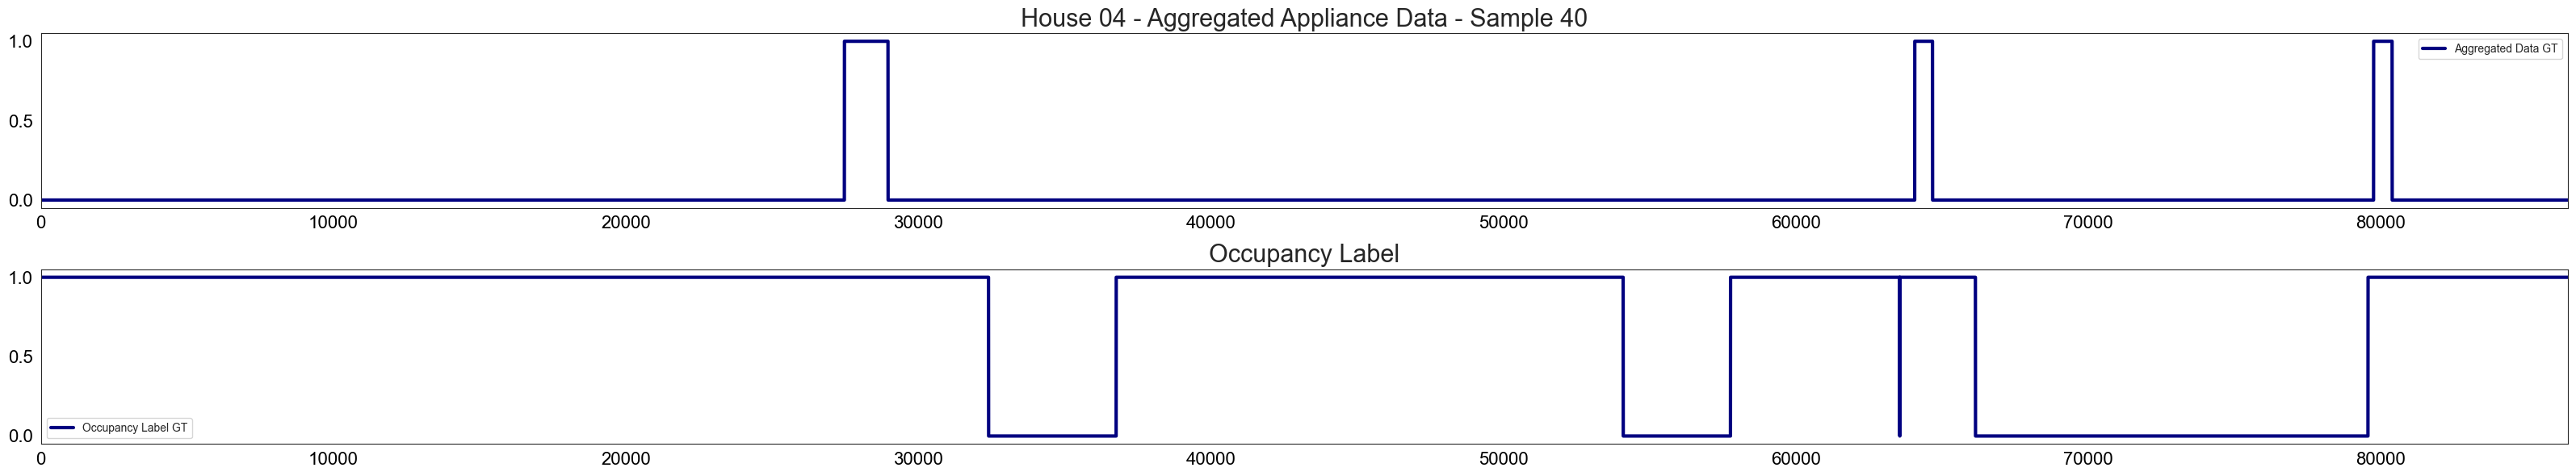

In [18]:
segment_length = 86400
i = random.randint(0, X_Data_AGG.shape[0]-1)
'''Dishwasher'''
plt.figure(figsize=(32,6))
plt.subplot(2,1,1)
plt.plot(X_Data_AGG[i,:,0], linewidth=3, label='Aggregated Data GT', color='navy')
plt.title(f"House 04 - Aggregated Appliance Data - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Occupancy Label'''
plt.subplot(2,1,2)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

Cleanse and Save House 04 data for the combined approach

In [20]:
# Curate
X_Data_Shape = X_Data_AGG.shape
Y_Data_Shape = Y_Data.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_Curated = np.zeros((sample_num,segment_length,num_channels))
Y_Data_Curated = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_AGG[i,:,:]
    Y_Data_Temp = Y_Data[i,:,:]
    Y_Data_Temp_SUM = np.sum(Y_Data_Temp)
    if (Y_Data_Temp_SUM < np.round(0.01*segment_length)) or (Y_Data_Temp_SUM > np.round(0.99*segment_length)):
        continue
    if (np.var(X_Data_Temp) > 0.0001):
        X_Data_Curated[counter,:,:] = X_Data_Temp
        Y_Data_Curated[counter,:,:] = Y_Data_Temp
        counter = counter + 1
X_Data_Curated = np.int_(X_Data_Curated[0:counter,:,:])
Y_Data_Curated = np.int_(Y_Data_Curated[0:counter,:,:])
print(X_Data_Curated.shape)
print(Y_Data_Curated.shape)
print(np.unique(X_Data_Curated))
print(np.unique(Y_Data_Curated))
# Save
data_dic = {"X_Data": X_Data_Curated,
            "Y_Data": Y_Data_Curated,
            }
savemat("Occupancy_Data_Curated_House_04_V2.mat", data_dic, format='5')

(43, 86400, 1)
(43, 86400, 1)
[0 1]
[0 1]


Create Folds - Train and Test Sets - 20% for Test - 10% for Validation

In [ ]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data_AGG, Y_Data, test_size=0.2, random_state=0)
X_Val = X_Test
Y_Val = Y_Test
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)
print(X_Val.shape)
print(Y_Val.shape)

(68, 86400, 1)
(68, 86400, 1)
(18, 86400, 1)
(18, 86400, 1)
(18, 86400, 1)
(18, 86400, 1)


Overlap Train Set

In [ ]:
# Overlap
X_Data_Shape = X_Train.shape
Y_Data_Shape = Y_Train.shape
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
print(X_Data_Shape)
print(Y_Data_Shape)
# Reshape Array
X_Data_Reshaped = np.reshape(X_Train, (X_Data_Shape[0]*X_Data_Shape[1], num_channels))
Y_Data_Reshaped = np.reshape(Y_Train, (Y_Data_Shape[0]*Y_Data_Shape[1], 1))
X_Data_Reshaped_Shape = X_Data_Reshaped.shape
Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
print(X_Data_Reshaped_Shape)
print(Y_Data_Reshaped_Shape)
# Overlap
overlap_ratio = 0.9
offset_amount = np.int_(segment_length*(1 - overlap_ratio))
X_Data_New = np.zeros((2000,segment_length,num_channels))
Y_Data_New = np.zeros((2000,segment_length,1))
num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/offset_amount))
counter = 0
for i in range(0,num_segments_approx):
    if (i*offset_amount+segment_length) > X_Data_Reshaped_Shape[0]:
        continue
    X_Data_Temp = X_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    X_Data_New[counter,:,:] = X_Data_Temp
    Y_Data_Temp = Y_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    Y_Data_New[counter,:,:] = Y_Data_Temp
    counter = counter + 1
X_Train_OVRL = X_Data_New[0:counter,:,:]
Y_Train_OVRL = Y_Data_New[0:counter,:,:]
print(X_Train_OVRL.shape)
print(Y_Train_OVRL.shape)

(68, 86400, 1)
(68, 86400, 1)
(5875200, 1)
(5875200, 1)
(671, 86400, 1)
(671, 86400, 1)


Transform Labels for Classification

In [ ]:
def transform_labels(X_Data_OVRL, Y_Data_OVRL, segment_length, num_channels):
    X_Data_New = np.zeros((20000,num_channels,segment_length))
    Y_Data_New = np.zeros((20000,1), dtype=int)
    ## Raw Dataset
    X_Data_Shape = X_Data_OVRL.shape
    Y_Data_Shape = Y_Data_OVRL.shape
    # Reshape Array
    X_Data_Reshaped = np.reshape(X_Data_OVRL, (X_Data_Shape[0]*X_Data_Shape[1], num_channels))
    Y_Data_Reshaped = np.reshape(Y_Data_OVRL, (Y_Data_Shape[0]*Y_Data_Shape[1], 1))
    X_Data_Reshaped_Shape = X_Data_Reshaped.shape
    Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
    num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/segment_length))
    counter = 0
    for i in range(0,num_segments_approx):
        if ((i+1)*segment_length) > X_Data_Reshaped_Shape[0]:
            continue
        X_Data_Temp = np.transpose(X_Data_Reshaped[i*segment_length:(i+1)*segment_length,:])
        X_Data_Temp_Mean = np.mean(X_Data_Temp)
        X_Data_Temp_VAR = np.var(X_Data_Temp)
        X_Data_New[counter,:,:] = X_Data_Temp
        Y_Data_Temp = Y_Data_Reshaped[i*segment_length:(i+1)*segment_length,:]
        Y_Data_Temp_Mean = np.mean(Y_Data_Temp)
        Y_Data_Temp_VAR = np.var(Y_Data_Temp)
        Y_Data_Temp_SUM = np.sum(Y_Data_Temp)
        if X_Data_Temp_VAR <= 0.001:
            continue
        # if Y_Data_Temp_VAR <= 0.001:
            # continue
        if (Y_Data_Temp_SUM < np.round(0.1*segment_length)) or (Y_Data_Temp_SUM > np.round(0.90*segment_length)):
            continue
        # if Y_Data_Temp_SUM == segment_length:
            # continue
        if Y_Data_Temp_Mean > 0.5:
            Y_Label = 1
        else:
            Y_Label = 0
        Y_Data_New[counter,:] = Y_Label
        counter = counter + 1
    X_Data_New = X_Data_New[0:counter,:,:]
    Y_Data_New = Y_Data_New[0:counter,:]
    return X_Data_New, Y_Data_New

In [ ]:
segment_length = 1200  # 20 Minutes = 1200 Data Points (1 Hz sampling rate)
X_Train_C, Y_Train_C = transform_labels(X_Train_OVRL, Y_Train_OVRL, segment_length, num_channels)
X_Test_C, Y_Test_C = transform_labels(X_Test, Y_Test, segment_length, num_channels)
X_Val_C, Y_Val_C = transform_labels(X_Test, Y_Test, segment_length, num_channels)
print(X_Train_C.shape)
print(Y_Train_C.shape)
print(X_Test_C.shape)
print(Y_Test_C.shape)
print(X_Val_C.shape)
print(Y_Val_C.shape)
labels, counts = np.unique(Y_Train_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Test_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Val_C, return_counts=True)
print(labels, counts)


(168, 1, 1200)
(168, 1)
(3, 1, 1200)
(3, 1)
(3, 1, 1200)
(3, 1)
[0 1] [ 64 104]
[0 1] [2 1]
[0 1] [2 1]


Balance train set (if required)

In [ ]:
Y_Train_0_indices = np.where(Y_Train_C == 0)[0]
X_Train_C_0 = np.take(X_Train_C, Y_Train_0_indices, axis=0)
Y_Train_C_0 = np.take(Y_Train_C, Y_Train_0_indices, axis=0)
Y_Train_1_indices = np.where(Y_Train_C == 1)[0]
X_Train_C_1 = np.take(X_Train_C, Y_Train_1_indices, axis=0)
Y_Train_C_1 = np.take(Y_Train_C, Y_Train_1_indices, axis=0)
#
Y_Train_C_0_shape = Y_Train_C_0.shape
Y_Train_C_1_shape = Y_Train_C_1.shape
Y_Train_C_shape = Y_Train_C.shape
if Y_Train_C_1_shape[0] > Y_Train_C_0_shape[0]:
    index = np.random.choice(Y_Train_C_1_shape[0], Y_Train_C_0_shape[0], replace=False)
    X_Train_1 = X_Train_C_1[index]
    Y_Train_1 = Y_Train_C_1[index]
    X_Train = np.concatenate([X_Train_C_0, X_Train_1], axis=0)
    Y_Train = np.concatenate([Y_Train_C_0, Y_Train_1], axis=0)
elif Y_Train_C_0_shape[0] > Y_Train_C_1_shape[0]:
    index = np.random.choice(Y_Train_C_0_shape[0], Y_Train_C_1_shape[0], replace=False)
    X_Train_0 = X_Train_C_0[index]
    Y_Train_0 = Y_Train_C_0[index]
    X_Train = np.concatenate([X_Train_C_1, X_Train_0], axis=0)
    Y_Train = np.concatenate([Y_Train_C_1, Y_Train_0], axis=0)
#
X_Train_C = X_Train
Y_Train_C = Y_Train
print(X_Train_C.shape)
print(Y_Train_C.shape)

(974, 8, 1200)
(974, 1)


In [ ]:
train_data_dic = {"X_Train": X_Train_C,
                  "Y_Train": Y_Train_C,
                  "X_Test": X_Test_C,
                  "Y_Test": Y_Test_C,
                  "X_Val": X_Test_C,
                  "Y_Val": Y_Test_C,
                  }
savemat("Data/Data_Fold_1.mat", train_data_dic, format='5')

Garbage Collector

In [ ]:
import gc #Garbage Collector
fl_Data = None
X_Test = None
X_Train = None
X_Val = None
Y_Test = None
Y_Train = None
Y_Val = None
gc.collect()

0

# MAIN

## Configurations

In [ ]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TRAIN"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'val_size': 0.0,  # Validation percentage for splitting
    'q_order': 3,  # q-order for the Self-ONN or Super-ONN Models
    'batch_size': 2,  # Batch Size, Change to fit hardware
    'lossType': 'SoftM_MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'optim_fc': 'Adam',  # 'Adam' or 'SGD'
    'lr': 0.0005,  # learning rate
    'stop_criteria': 'accuracy',  # Stopping criteria: 'loss' or 'accuracy'
    'n_epochs': 500,  # number of training epochs
    'epochs_patience': 6,
    'lr_factor': 0.1,  # lr_factor, if val loss did not decrease for a number of epochs (epochs_patience) then decrease learning rate by a factor of lr_factor
    'max_epochs_stop': 30,  # maximum number of epochs with no improvement in validation loss for early stopping
    'num_folds': 1,  # number of cross validation folds
    'load_model': False,  # load model: True or False
    'load_model_path': 'Results_Classification\RODNet_Occp_Classification\Fold_1\RODNet_Occp_Classification_fold_1.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'model_to_load': 'RODNet',  # choose one of the following models: 'CNN_1' 'CNN_2' 'CNN_2' 'CNN_3' 'SelfResNet18' 'ResNet'
    'model_name': 'RODNet_Occp_Classification',  # choose a unique name for result folder
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': 1,  # The starting fold for training
    'fold_last': 1,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}

# SAVE CONFIG FILE
with open(r"Config_Train.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()

print("Config file 'Config_Train.ini' created")

Config file 'Config_Train.ini' created


## Train

In [ ]:
%run -i Train.py

Train on gpu: True
1 GPUs detected.
Training using RODNet network
Starting training with Fold 1
Shape of Train Data: (168, 1, 1200)
Shape of Train Label: (168, 1)
Shape of Validation Data: (3, 1, 1200)
Shape of Validation Label: (3, 1)
Shape of Test Data: (3, 1, 1200)
Shape of Test Label: (3, 1)
Classes: [0 1]
No. of Classes: 2
model device: cuda
Starting Training from Scratch.



Epoch 0: 100%|██████████| 84/84 [00:01<00:00, 59.77it/s]
c:\Users\Sakib Mahmud\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch: 0 	Training Loss: 0.2439 	Validation Loss: 0.3255 	Test Loss: 0.3255
		Training Accuracy: 61.31%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 1: 100%|██████████| 84/84 [00:01<00:00, 79.85it/s]



Epoch: 1 	Training Loss: 0.2420 	Validation Loss: 0.3076 	Test Loss: 0.3076
		Training Accuracy: 63.10%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 2: 100%|██████████| 84/84 [00:01<00:00, 80.04it/s]



Epoch: 2 	Training Loss: 0.2399 	Validation Loss: 0.4386 	Test Loss: 0.4386
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 3: 100%|██████████| 84/84 [00:01<00:00, 81.24it/s]



Epoch: 3 	Training Loss: 0.2378 	Validation Loss: 0.3259 	Test Loss: 0.3259
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 4: 100%|██████████| 84/84 [00:01<00:00, 75.66it/s]



Epoch: 4 	Training Loss: 0.2408 	Validation Loss: 0.2973 	Test Loss: 0.2973
		Training Accuracy: 61.31%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 5: 100%|██████████| 84/84 [00:01<00:00, 82.27it/s]



Epoch: 5 	Training Loss: 0.2431 	Validation Loss: 0.2689 	Test Loss: 0.2689
		Training Accuracy: 59.52%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 6: 100%|██████████| 84/84 [00:00<00:00, 87.02it/s]



Epoch: 6 	Training Loss: 0.2366 	Validation Loss: 0.3854 	Test Loss: 0.3854
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 7: 100%|██████████| 84/84 [00:00<00:00, 88.35it/s]



Epoch: 7 	Training Loss: 0.2383 	Validation Loss: 0.4026 	Test Loss: 0.4026
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 8: 100%|██████████| 84/84 [00:01<00:00, 83.64it/s]



Epoch: 8 	Training Loss: 0.2387 	Validation Loss: 0.3259 	Test Loss: 0.3259
		Training Accuracy: 60.71%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 9: 100%|██████████| 84/84 [00:01<00:00, 83.32it/s]



Epoch: 9 	Training Loss: 0.2339 	Validation Loss: 0.5166 	Test Loss: 0.5166
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 10: 100%|██████████| 84/84 [00:01<00:00, 83.46it/s]



Epoch: 10 	Training Loss: 0.2354 	Validation Loss: 0.4441 	Test Loss: 0.4441
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 11: 100%|██████████| 84/84 [00:01<00:00, 83.57it/s]



Epoch: 11 	Training Loss: 0.2393 	Validation Loss: 0.2957 	Test Loss: 0.2957
		Training Accuracy: 60.71%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 12: 100%|██████████| 84/84 [00:00<00:00, 85.08it/s]



Epoch: 12 	Training Loss: 0.2313 	Validation Loss: 0.2888 	Test Loss: 0.2888
		Training Accuracy: 61.31%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 13: 100%|██████████| 84/84 [00:00<00:00, 87.02it/s]



Epoch: 13 	Training Loss: 0.2442 	Validation Loss: 0.4226 	Test Loss: 0.4226
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 14: 100%|██████████| 84/84 [00:00<00:00, 89.48it/s]



Epoch: 14 	Training Loss: 0.2376 	Validation Loss: 0.2819 	Test Loss: 0.2819
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 15: 100%|██████████| 84/84 [00:00<00:00, 89.58it/s]



Epoch: 15 	Training Loss: 0.2362 	Validation Loss: 0.2741 	Test Loss: 0.2741
		Training Accuracy: 61.31%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 16: 100%|██████████| 84/84 [00:00<00:00, 89.76it/s]



Epoch: 16 	Training Loss: 0.2333 	Validation Loss: 0.3084 	Test Loss: 0.3084
		Training Accuracy: 61.31%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 17: 100%|██████████| 84/84 [00:00<00:00, 89.57it/s]



Epoch: 17 	Training Loss: 0.2304 	Validation Loss: 0.2946 	Test Loss: 0.2946
		Training Accuracy: 60.71%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 18: 100%|██████████| 84/84 [00:00<00:00, 87.51it/s]



Epoch: 18 	Training Loss: 0.2376 	Validation Loss: 0.2688 	Test Loss: 0.2688
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 19: 100%|██████████| 84/84 [00:01<00:00, 77.57it/s]



Epoch: 19 	Training Loss: 0.2252 	Validation Loss: 0.3155 	Test Loss: 0.3155
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 20: 100%|██████████| 84/84 [00:01<00:00, 83.56it/s]



Epoch: 20 	Training Loss: 0.2312 	Validation Loss: 0.3007 	Test Loss: 0.3007
		Training Accuracy: 61.31%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 21: 100%|██████████| 84/84 [00:01<00:00, 76.14it/s]



Epoch: 21 	Training Loss: 0.2270 	Validation Loss: 0.2836 	Test Loss: 0.2836
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 22: 100%|██████████| 84/84 [00:01<00:00, 62.14it/s]



Epoch: 22 	Training Loss: 0.2314 	Validation Loss: 0.2607 	Test Loss: 0.2607
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 23: 100%|██████████| 84/84 [00:01<00:00, 58.90it/s]



Epoch: 23 	Training Loss: 0.2292 	Validation Loss: 0.3344 	Test Loss: 0.3344
		Training Accuracy: 63.10%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 24: 100%|██████████| 84/84 [00:01<00:00, 70.20it/s]



Epoch: 24 	Training Loss: 0.2305 	Validation Loss: 0.2899 	Test Loss: 0.2899
		Training Accuracy: 60.71%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 25: 100%|██████████| 84/84 [00:01<00:00, 64.65it/s]



Epoch: 25 	Training Loss: 0.2282 	Validation Loss: 0.2449 	Test Loss: 0.2449
		Training Accuracy: 60.12%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 26: 100%|██████████| 84/84 [00:01<00:00, 59.42it/s]



Epoch: 26 	Training Loss: 0.2264 	Validation Loss: 0.2946 	Test Loss: 0.2946
		Training Accuracy: 61.90%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 27: 100%|██████████| 84/84 [00:01<00:00, 57.36it/s]



Epoch: 27 	Training Loss: 0.2268 	Validation Loss: 0.3442 	Test Loss: 0.3442
		Training Accuracy: 61.31%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 28: 100%|██████████| 84/84 [00:01<00:00, 59.62it/s]



Epoch: 28 	Training Loss: 0.2288 	Validation Loss: 0.2871 	Test Loss: 0.2871
		Training Accuracy: 63.10%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 29: 100%|██████████| 84/84 [00:01<00:00, 60.01it/s]



Epoch: 29 	Training Loss: 0.2225 	Validation Loss: 0.3134 	Test Loss: 0.3134
		Training Accuracy: 64.29%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%


Epoch 30: 100%|██████████| 84/84 [00:01<00:00, 55.97it/s]



Epoch: 30 	Training Loss: 0.2223 	Validation Loss: 0.2987 	Test Loss: 0.2987
		Training Accuracy: 66.07%	 Validation Accuracy: 33.33%	 Test Accuracy: 33.33%

Early Stopping! Total epochs: 30. Best epoch: 0 with loss: 0.33 and acc: 33.33%
35.63 total seconds elapsed. 1.15 seconds per epoch.
Test Loss: 0.3255,  Test Accuracy: 33.33%
completed fold 1
#############################################################
Cummulative Confusion Matrix
[[0 2]
 [0 1]]
Overall Test Accuracy: 33.33
#############################################################


## Test

In [ ]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TEST"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'batch_size': 1,  # Batch Size, Change to fit hardware
    'lossType': 'SoftM_MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'num_folds': 1,  # number of cross validation folds
    'CI': 0.9,  # Confidence interval (missied cases with probability>=CI will be reported in excel file)
    'load_model': False,  # specify path of pretrained model wieghts or set to False to train from scratch
    'load_model_path': 'Results_Classification\RODNet_Occp_Classification\Fold_1\RODNet_Occp_Classification_fold_1.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'labeled_data': True,  # set to true if you have the labeled test set
    'model_name': 'RODNet_Occp_Classification',  # name of the saved model
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': 1,  # The starting fold for training
    'fold_last': 1,  # The last fold for training
    'N_steps': 1000,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}
# SAVE CONFIG FILE
with open(r"Config_Test.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()
print("Config file 'Config_Test.ini' created")

Config file 'Config_Test.ini' created


In [ ]:
%run -i Test.py